In [1]:
using Flux
using Zygote
using Plots

import Pkg
Pkg.status("Flux")

Status `~/.julia/environments/v1.8/Project.toml`
  [587475ba] Flux v0.13.10


### <span style="color:orange"> Float32 is important because that is single precision on most GPUs </span>

In [2]:
#generate some target values from this function (non-linear)
function fn1(x)
    if( x < -5 )
        return 1
    elseif( -5 <= x <= 0 )
        return 2
    else 
        return 2x + 2
    end
end

fn1 (generic function with 1 method)

In [3]:
#span a domain to get the training data and then get some random domain points to test on
x_train, x_test = collect(-10:0.1:10), (rand(200) .* 12) .- 10

([-10.0, -9.9, -9.8, -9.7, -9.6, -9.5, -9.4, -9.3, -9.2, -9.1  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], [-1.9107595745520847, -3.033997453934636, -6.983774901472833, -0.6945315526223883, -1.1341879811107347, -5.154009675873426, -0.21103415019355154, -8.91697847647487, -7.506981912405983, -3.0702898267359338  …  -7.207357115973084, -7.697260522424015, -7.644870991287368, -5.043665284474329, -8.262312678997926, -5.159809019101004, 1.7558698793460543, -0.006786715752451045, -4.959756575476319, -3.742620573101947])

In [4]:
y_train, y_test = fn1.(x_train), fn1.(x_test)

(Real[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0], Real[2, 2, 1, 2, 2, 1, 2, 1, 1, 2  …  1, 1, 1, 1, 1, 1, 5.511739758692109, 2, 2, 2])

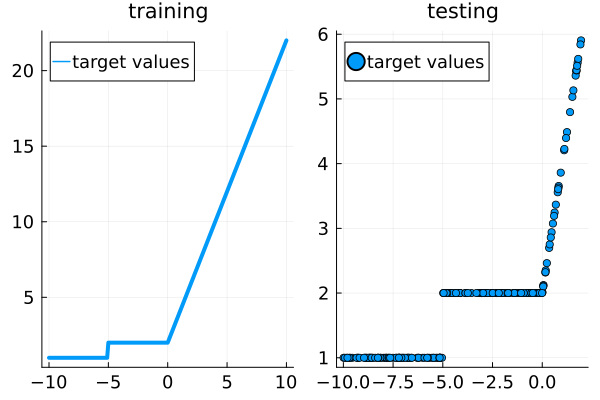

In [5]:
p1 = plot( x_train , y_train , linewidth=4 , title="training" , label="target values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
p2 = plot( x_test , y_test , seriestype=:scatter , linewidth=4 , title="testing" , label="target values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
plot(p1,p2)

In [6]:
#let's make a simple model to predict this data
model = Chain( Dense(1=>20,sigmoid) , Dense(20=>5,relu) , Dense(5=>1) )

Chain(
  Dense(1 => 20, σ),                    # 40 parameters
  Dense(20 => 5, relu),                 # 105 parameters
  Dense(5 => 1),                        # 6 parameters
)                   # Total: 6 arrays, 151 parameters, 988 bytes.

In [7]:
length(model)

3

In [8]:
model[1]

Dense(1 => 20, σ)   # 40 parameters

In [9]:
#look at the weights at initialization
display(model[1].weight)
display(model[2].weight)
display(model[3].weight)

20×1 Matrix{Float32}:
 -0.48046696
  0.4686589
  0.21337906
 -0.34418133
 -0.34746253
 -0.41341054
 -0.1866218
  0.4602044
  0.41900957
  0.4346656
 -0.06361885
 -0.3639663
  0.21686913
  0.25479516
 -0.25583234
 -0.07866163
 -0.20596166
 -0.24833441
 -0.26317525
 -0.4647454

5×20 Matrix{Float32}:
  0.319423    0.462702     0.180164   …  -0.130999    0.311259    -0.019595
  0.239587    0.134254     0.325317      -0.180594    0.292177    -0.0952659
 -0.271544   -0.00886629  -0.30236       -0.392736   -0.00535304   0.468539
 -0.366142   -0.428786     0.451615       0.0561868  -0.409084     0.360007
 -0.0198171  -0.384587    -0.0581854      0.0717013   0.311499    -0.249292

1×5 Matrix{Float32}:
 0.523178  0.562815  0.349835  -0.0456347  0.194497

In [10]:
#put the independent samples along the -columns-
init_predictions = model( hcat(x_test...) )

1×200 Matrix{Float64}:
 0.527159  0.572471  0.658041  0.469817  …  0.435859  0.627864  0.596213

In [11]:
#get the -initial- loss
#let's use mean absolute error (MAE) here rather than MSE to not focus too much on big values
init_loss = Flux.mae( init_predictions' , y_test )

1.423219263207021

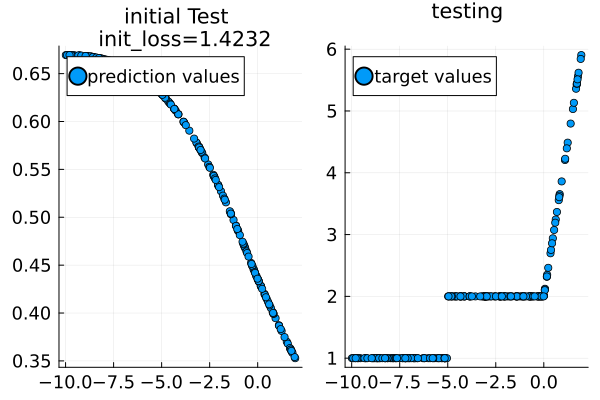

In [12]:
p1 = plot( x_test , init_predictions' , seriestype=:scatter , linewidth=4 , title="initial Test \n init_loss=$(round(init_loss,digits=4))" , 
            label="prediction values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
p2 = plot( x_test , y_test , seriestype=:scatter , linewidth=4 , title="testing" , label="target values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
plot(p1,p2)

In [13]:
#pack the data
data = Flux.DataLoader( (x_train, y_train) , batchsize=20, shuffle=true )

MLUtils.DataLoader{Tuple{Vector{Float64}, Vector{Real}}, Random._GLOBAL_RNG, Val{nothing}}(([-10.0, -9.9, -9.8, -9.7, -9.6, -9.5, -9.4, -9.3, -9.2, -9.1  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], Real[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0]), 20, false, true, true, false, Val{nothing}(), Random._GLOBAL_RNG())

In [14]:
opt = Flux.setup( Flux.Adam(0.01) , model )

(layers = ((weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(

In [15]:
#train the parameters
loss( model , x , y ) = Flux.mae( model(hcat(x...))' , y )
for epoch in 1:5000
    
    Flux.train!( loss , model , data , opt )
    
end


In [16]:
last_loss = Flux.mae( model( hcat(x_test...) )' , y_test )

0.037186678395450416

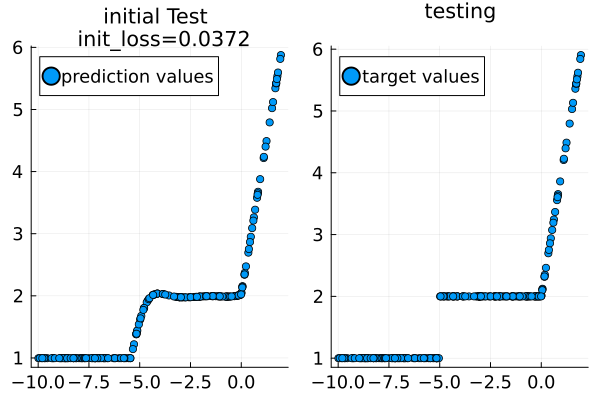

In [17]:
p1 = plot( x_test , model( hcat(x_test...) )' , seriestype=:scatter , linewidth=4 , title="initial Test \n init_loss=$(round(last_loss,digits=4))" , 
            label="prediction values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
p2 = plot( x_test , y_test , seriestype=:scatter , linewidth=4 , title="testing" , label="target values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
plot(p1,p2)

### <span style="color:orange"> Let's do some categorical data prediction with the dataset we all are familiar with: **Iris** </span>

There is a nice Julia package to use the plethora of R datasets

In [115]:
using RDatasets

In [116]:
iris = dataset("datasets", "iris")

Row,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa


In [117]:
typeof(iris)

DataFrame

In [118]:
iris = Matrix(iris)
typeof(iris)
display( iris[1:3,:])

3×5 Matrix{Any}:
 5.1  3.5  1.4  0.2  "setosa"
 4.9  3.0  1.4  0.2  "setosa"
 4.7  3.2  1.3  0.2  "setosa"

In [119]:
features = iris[:,1:4]
features = Matrix{Float32}(features) #the numbers need to be in Float32
println( typeof( features ) )
targets = iris[:,5];

Matrix{Float32}


In [120]:
length( unique( iris[:,end] ) )

3

In [121]:
length( iris[:,end] )

150

In [122]:
using StatsBase, Random

In [123]:
# rand_inds = randperm(150)
# train_inds = rand_inds[1:100];
# test_inds = rand_inds[101:end];
odd_inds = findall( mod.(1:150,2) .== 1)
even_inds = findall( mod.(1:150,2) .== 0);

In [124]:
x_train , x_test = features[odd_inds,:] , features[even_inds,:];
y_train , y_test = targets[odd_inds] , targets[even_inds];
println( size(x_train) )
x_train = x_train'
x_test = x_test'
println( size(x_train) )

(75, 4)
(4, 75)


In [125]:
#we need to make 1-hot encoding of the categorical values
species = unique( iris[:,end] )
y_train = Flux.onehotbatch( y_train , species )
display( size(y_train) )
y_test = Flux.onehotbatch( y_test , species )

(3, 75)

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [126]:
#make a model for predicting the species (categorical output)
model_iris = Chain(Dense(4=>8,relu),Dense(8=>3),softmax)

Chain(
  Dense(4 => 8, relu),                  # 40 parameters
  Dense(8 => 3),                        # 27 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 67 parameters, 524 bytes.

In [127]:
#test the model
println( "model output = " , model_iris( x_train[:,1] ) )
println( "category output predicted ('one-cold') = " , Flux.onecold( model_iris(x_train[:,1]), species ) )
println( "true output label = " , Flux.onecold( y_train[:,1], species ) )
#try out the cross entropy
println( "cross entropy of prediction and target = " , Flux.crossentropy( model_iris( x_train[:,1] ) , y_train[:,1] ) )
println( "cross entropy of predictions and multiple targets = " , Flux.crossentropy( model_iris( x_train[:,1:20] ) , y_train[:,1:20] ) )
hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "init accuracy = ", accuracy , "%")

model output = Float32[0.40554413, 0.30990797, 0.28454784]
category output predicted ('one-cold') = setosa
true output label = setosa
cross entropy of prediction and target = 0.9025253
cross entropy of predictions and multiple targets = 0.896403
init accuracy = 34.666666666666664%


In [128]:
#pack the data
data = Flux.DataLoader( (x_train, y_train) , batchsize=10 , shuffle=true );
#data = [(x_train,y_train)]

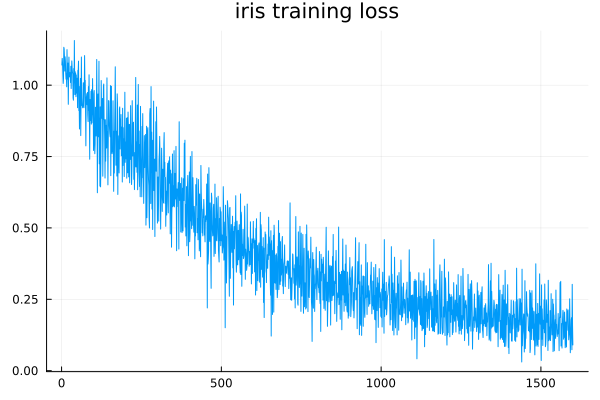

In [129]:
#train the parameters to predict iris
opt = Flux.setup( Flux.Adam(0.001) , model_iris );
losses = []
for epoch in 1:200
    for data_tmp in data    
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_iris) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt, model_iris, grads[1])
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="iris training loss" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

In [130]:
hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris train accuracy = ", accuracy , "%")

hits = Flux.onecold( model_iris( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris test accuracy = ", accuracy , "%")

Iris train accuracy = 96.0%
Iris test accuracy = 97.33333333333333%


In [131]:
# function loss_iris( m , x , y )
#     return Flux.logitcrossentropy( m( x ) , y )
# end
# for epoch in 1:100
#     Flux.train!( loss_iris , model_iris , data , opt )
# end

In [134]:
x = 1
x == nothing 

false

### <span style="color:orange"> Instead of using Adam (with momentums) how about doing classic gradient decent with eta ($\eta$) parameter on the gradients for each parameter in the model </span>

Iris train accuracy = 96.0%
Iris test accuracy = 94.66666666666667%


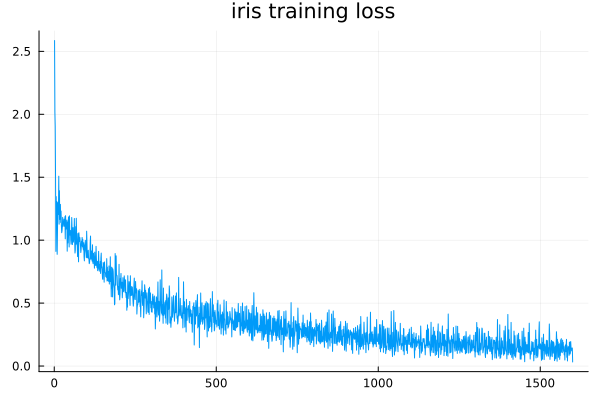

In [139]:
model_iris = Chain(Dense(4=>8,relu),Dense(8=>3),softmax)
data = Flux.DataLoader( (x_train, y_train) , batchsize=10 , shuffle=true );

# the gradient descent step size
eta = 0.01 
opt = Flux.setup( Flux.Adam(0.001) , model_iris );

losses = []
for epoch in 1:200
    for data_tmp in data    
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_iris) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        #Flux.update!(opt, model_iris, grads[1])
        fmap(model_iris, grads[1]) do p, g #custom gradient descent
            if( g != nothing && p != nothing )
                p .= p .- eta .* g
            end
        end
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end

hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris train accuracy = ", accuracy , "%")

hits = Flux.onecold( model_iris( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris test accuracy = ", accuracy , "%")

p1 = plot( losses , title="iris training loss" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

### <span style="color:orange"> Now let's try doing some **Regularization** on the parameters of the model to avoid over fitting </span>

In [204]:
using ChainRulesCore

In [225]:
# example of getting the parameters of the model
params = Flux.params(model_iris)
# get the total absolute sum of the model parameters
penalty = sum(sum.(abs,params))
println( penalty )
println( sum(p -> sum(abs, p), params) )

20.532154
20.532154


epoch=1, epoch=2, epoch=3, epoch=4, epoch=5, epoch=6, epoch=7, epoch=8, epoch=9, epoch=10, epoch=11, epoch=12, epoch=13, epoch=14, epoch=15, epoch=16, epoch=17, epoch=18, epoch=19, epoch=20, Iris train accuracy = 70.66666666666667%
Iris test accuracy = 76.0%
penalty params init = 8.40794
penalty params final = 9.224549


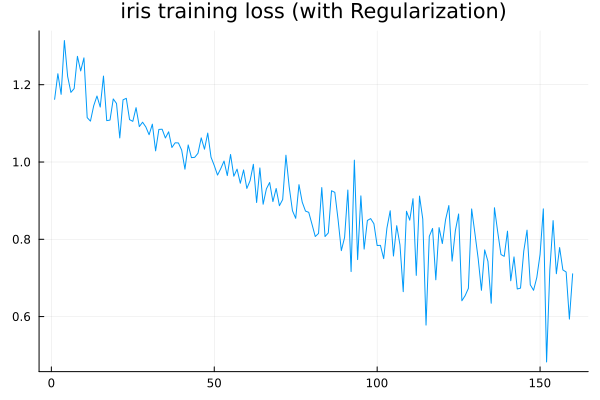

In [230]:
model_iris = Chain(Dense(4=>8,relu),Dense(8=>3),softmax)
data = Flux.DataLoader( (x_train, y_train) , batchsize=10 , shuffle=true );

opt = Flux.setup( Flux.Adam(0.001) , model_iris );

lambda = 0.5 #for the penalty scaling on the parameters of the model
penalty_init = sum( sum.( abs2 , Flux.params(model_iris) ) )

losses = []
for epoch in 1:20
    for data_tmp in data    
        #get the gradients
        
        loss_tmp, grads = Flux.withgradient(model_iris) do model
            
            y_hat = model(data_tmp[1])
            #get the penalty term and add it to the loss
#             params_tmp = Flux.params(model)
#             penalty = 0
#             ChainRulesCore.ignore_derivatives() do
#                 penalty = sum(p -> sum(abs, p), params) #sum(sum.(abs,params)) #my_penalty(params_tmp) 
#             end
            Flux.crossentropy(y_hat,data_tmp[2]) #.+ lambda*penalty
        end
        Flux.update!(opt, model_iris, grads[1])

        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
    print("epoch=$(epoch), ")
end

hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris train accuracy = ", accuracy , "%")

hits = Flux.onecold( model_iris( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris test accuracy = ", accuracy , "%")

penalty_final = sum( sum.( abs2 , Flux.params(model_iris) ) )
println( "penalty params init = ", penalty_init )
println( "penalty params final = ", penalty_final )

p1 = plot( losses , title="iris training loss (with Regularization)" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

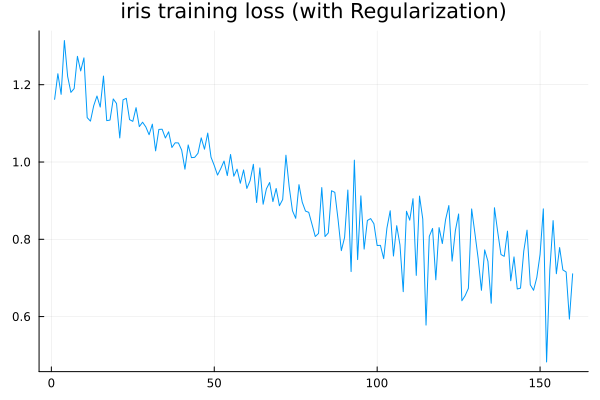

In [231]:
savefig("./p1.png") #save the plot in the current directory
display(p1)

### <span style="color:orange"> Now let's look at the famous Titanic dataset and use features categorical to predict categorical </span>

In [35]:
titanic = dataset("datasets", "Titanic")

Row,Class,Sex,Age,Survived,Freq
,String7,String7,String7,String3,Int64
1,1st,Male,Child,No,0
2,2nd,Male,Child,No,0
3,3rd,Male,Child,No,35
4,Crew,Male,Child,No,0
5,1st,Female,Child,No,0
6,2nd,Female,Child,No,0
7,3rd,Female,Child,No,17
8,Crew,Female,Child,No,0
9,1st,Male,Adult,No,118


In [36]:
size( titanic )

(32, 5)

In [37]:
#titanic = Matrix(titanic)
features = Array{String}(titanic[:,1:3])
targets = Array{String}(titanic[:,4])
println( size(features) )

(32, 3)


In [38]:
targets

32-element Vector{String}:
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 "No"
 ⋮
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"
 "Yes"

In [39]:
features

32×3 Matrix{String}:
 "1st"   "Male"    "Child"
 "2nd"   "Male"    "Child"
 "3rd"   "Male"    "Child"
 "Crew"  "Male"    "Child"
 "1st"   "Female"  "Child"
 "2nd"   "Female"  "Child"
 "3rd"   "Female"  "Child"
 "Crew"  "Female"  "Child"
 "1st"   "Male"    "Adult"
 "2nd"   "Male"    "Adult"
 "3rd"   "Male"    "Adult"
 "Crew"  "Male"    "Adult"
 "1st"   "Female"  "Adult"
 ⋮                 
 "1st"   "Female"  "Child"
 "2nd"   "Female"  "Child"
 "3rd"   "Female"  "Child"
 "Crew"  "Female"  "Child"
 "1st"   "Male"    "Adult"
 "2nd"   "Male"    "Adult"
 "3rd"   "Male"    "Adult"
 "Crew"  "Male"    "Adult"
 "1st"   "Female"  "Adult"
 "2nd"   "Female"  "Adult"
 "3rd"   "Female"  "Adult"
 "Crew"  "Female"  "Adult"

In [40]:
rand_inds = randperm(32)
train_inds = rand_inds[1:28]
test_inds = rand_inds[20:end];

In [41]:
x_train , x_test = features[train_inds,:] , features[test_inds,:];
y_train , y_test = targets[train_inds] , targets[test_inds];
println( size(x_train) )


(28, 3)


In [42]:
#place the features in 1-hot encoding where each categorical variable itself needs its own encoding and then concatenation of each variable together
col1_unique = unique(features[:,1])
col2_unique = unique(features[:,2])
col3_unique = unique(features[:,3])

function features_OneHot(features)
    features_1hot = []
    for row in eachrow(features)
        sample_1hot = []
        for (index,col) in enumerate(row)
            if( index == 1 )
                push!( sample_1hot , Flux.onehot( col , col1_unique )... )
            elseif( index == 2 )
                push!( sample_1hot , Flux.onehot( col , col2_unique )... )
            else
                push!( sample_1hot , Flux.onehot( col , col3_unique )... )
            end        
        end
        if( size(features_1hot) != (0,) )
            features_1hot = [features_1hot  sample_1hot ]
        else
            features_1hot = sample_1hot
        end
    end
    return features_1hot
end

x_train = Array{Float32}(features_OneHot(x_train))
x_test = Array{Float32}(features_OneHot(x_test))

8×13 Matrix{Float32}:
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0
 1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0
 0.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0
 1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0

In [43]:
function target_OneHot(targets)
    targets_new = zeros(size(targets)[1])
    yes_inds = findall(targets .== "Yes")
    targets_new[yes_inds] .= 1
    return targets_new
end
y_train = Array{Float32}(target_OneHot(y_train)')
y_test = Array{Float32}(target_OneHot(y_test)')

1×13 Matrix{Float32}:
 0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0

In [44]:
#make a model for predicting the survived (categorical output)
model_titanic = Chain( Dense(8=>20,sigmoid),Dense(20=>10,relu),Dense(10=>1,sigmoid) )

Chain(
  Dense(8 => 20, σ),                    # 180 parameters
  Dense(20 => 10, relu),                # 210 parameters
  Dense(10 => 1, σ),                    # 11 parameters
)                   # Total: 6 arrays, 401 parameters, 1.941 KiB.

In [45]:
println( "sample model output = " , model_titanic( x_train[:,1] ) )
println( "sample binary cross entropy loss = " , Flux.binarycrossentropy(model_titanic(x_train[:,1]),y_train[1])  )

sample model output = Float32[0.48730296]
sample binary cross entropy loss = 0.66806996


In [46]:
#pack the data
data = Flux.DataLoader( (x_train, y_train) , batchsize=2 , shuffle=true );

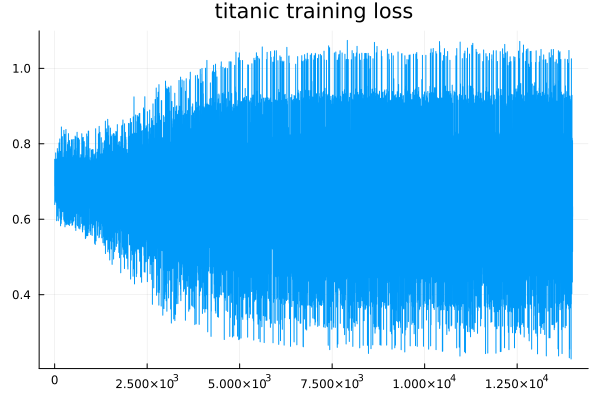

In [47]:
#train the parameters to predict iris
opt = Flux.setup( Flux.Adam(0.001) , model_titanic );
losses = []
for epoch in 1:1000
    for data_tmp in data    
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_titanic) do model
            y_hat = model(data_tmp[1])
            Flux.binarycrossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt, model_titanic, grads[1])
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="titanic training loss" , legend=false )
savefig("./p1.png") #save the plot in the current directory
display(p1)

In [48]:
mean( round.( model_titanic(x_train) ) .== y_train )

0.5714285714285714

In [49]:
mean( round.( model_titanic(x_test) ) .== y_test )

0.38461538461538464

### <span style="color:orange"> Let's try a dataset for titanic with more observations </span>

In [50]:
using CSV

In [51]:
titanic_data = CSV.File(open("titanic.csv")) |> DataFrame;

In [52]:
size( titanic_data )

(891, 12)

In [53]:
#drop rows that are containing a missing element
titanic_data = titanic_data[completecases(titanic_data), :];

In [54]:
size( titanic_data )

(183, 12)

In [55]:
titanic_data[1:3,:]

Row,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Int64,Int64,Int64,String,String7,Float64?,Int64,Int64,String31,Float64,String15?,String1?
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
3,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


In [56]:
names(titanic_data) #just like in R

12-element Vector{String}:
 "PassengerId"
 "Survived"
 "Pclass"
 "Name"
 "Sex"
 "Age"
 "SibSp"
 "Parch"
 "Ticket"
 "Fare"
 "Cabin"
 "Embarked"

In [57]:
#predict survived, binary target
targets = Array{Float32}(titanic_data[:,:Survived])'
println( targets[1:10] )

Float32[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0]


In [58]:
#use a mix of numerical and categorical as features
features_numerical = Matrix{Float32}( titanic_data[:,[:Pclass,:Age,:Fare]] );
#encode the 'female' as 1 and the 'male' as 0
features_categorical = Array{Float32}( [titanic_data[rr,:Sex] == "female" ? 1 : 0 for rr in 1:nrow(titanic_data)] )
features = hcat( features_numerical , features_categorical )'

4×183 adjoint(::Matrix{Float32}) with eltype Float32:
  1.0      1.0   1.0      3.0   1.0   …   1.0      1.0   1.0      1.0   1.0
 38.0     35.0  54.0      4.0  58.0      47.0     33.0  56.0     19.0  26.0
 71.2833  53.1  51.8625  16.7  26.55     52.5542   5.0  83.1583  30.0  30.0
  1.0      1.0   0.0      1.0   1.0       1.0      0.0   1.0      1.0   0.0

In [59]:
rand_inds = randperm( size(titanic_data)[1] )
train_inds = rand_inds[ 1 : Int(round(0.65*size(titanic_data)[1])) ]
test_inds = rand_inds[ 1 : Int(round(0.35*size(titanic_data)[1])) ];

In [60]:
x_train , x_test = features[:,train_inds] , features[:,test_inds];
y_train , y_test = Array{Float32}(targets[train_inds])' , Array{Float32}(targets[test_inds]');
println( size(y_train) )

(1, 119)


In [61]:
#make a model for predicting the survived (categorical output)
model_titanic = Chain( Dense(4=>8,relu),Dense(8=>3,relu),Dense(3=>1,sigmoid) )

Chain(
  Dense(4 => 8, relu),                  # 40 parameters
  Dense(8 => 3, relu),                  # 27 parameters
  Dense(3 => 1, σ),                     # 4 parameters
)                   # Total: 6 arrays, 71 parameters, 668 bytes.

In [62]:
println( "sample model output = " , model_titanic( x_train[:,1] ) )
println( "sample binary cross entropy loss = " , Flux.binarycrossentropy(model_titanic(x_train[:,1]),y_train[1]) )
println( "multiple model output = " , model_titanic( x_train[:,1:3] ) )
println("multiple binary cross entropy loss=",Flux.binarycrossentropy(model_titanic(x_train[:,1:3])',y_train[1,1:3]))

sample model output = Float32[0.5]
sample binary cross entropy loss = 0.69314694
multiple model output = Float32[0.5 0.5 0.9999068]
multiple binary cross entropy loss=0.462129


In [63]:
#pack the data
data = Flux.DataLoader( (x_train, y_train) , batchsize=4 , shuffle=true );

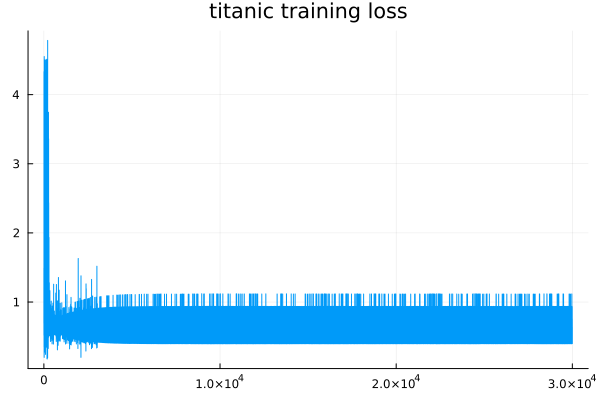

In [64]:
#train the parameters to predict iris
opt = Flux.setup( Flux.Adam(0.001) , model_titanic );
losses = []
for epoch in 1:1000
    for data_tmp in data   
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_titanic) do model
            y_hat = model(data_tmp[1])
            Flux.binarycrossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt, model_titanic, grads[1])
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="titanic training loss" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

In [65]:
println( "accuracy on training = " , 100 * mean( round.( model_titanic(x_train) ) .== y_train ) )

accuracy on training = 67.22689075630252


In [66]:
println( "accuracy on testing = " , 100 * mean( round.( model_titanic(x_test) ) .== y_test ) )

accuracy on testing = 75.0


### <span style="color:orange"> Let's log and visualize the changes to a single selected parameter weight value, eg layer 2, weight (2,1), and the **loss** in respect to it </span>

the gradient as choosing $\frac{ \partial f }{ \partial \theta_{2,2,3} } $ , partial derivative of the loss with respect layer 2, weight 2,1

In [80]:
#make a model for predicting the survived (categorical output)
model_titanic = Chain( Dense(4=>8,relu),Dense(8=>3,relu),Dense(3=>1,sigmoid) )

Chain(
  Dense(4 => 8, relu),                  # 40 parameters
  Dense(8 => 3, relu),                  # 27 parameters
  Dense(3 => 1, σ),                     # 4 parameters
)                   # Total: 6 arrays, 71 parameters, 668 bytes.

In [81]:
#layer 2, weight 2,1
weight_val = model_titanic.layers[1].weight[2,1]

-0.28623855f0

In [88]:
#partial derivative of the loss with respect layer 2, weight 2,1
grads = Flux.gradient(m -> Flux.binarycrossentropy(m(x_train[:,1]), y_train[1]), model_titanic)
grads[1].layers[1].weight[2,1]

-0.02115462f0

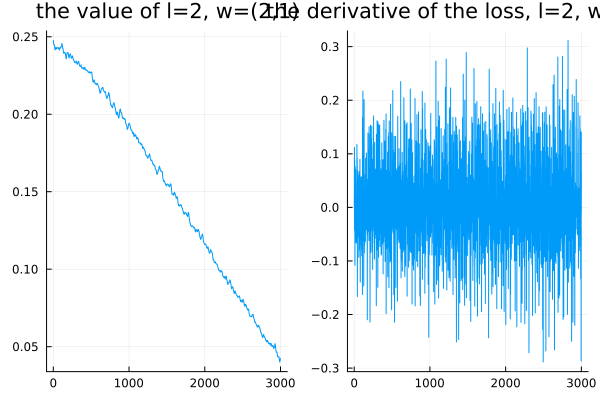

In [89]:
#train the parameters to predict iris

#pack the data
data = Flux.DataLoader( (x_train, y_train) , batchsize=4 , shuffle=true );
opt = Flux.setup( Flux.Adam(0.001) , model_titanic );
weight_vals = []
derivative_vals = []
for epoch in 1:100
    for data_tmp in data   
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_titanic) do model
            y_hat = model(data_tmp[1])
            Flux.binarycrossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt, model_titanic, grads[1])
        weight_val = model_titanic.layers[1].weight[2,1]
        push!(weight_vals,weight_val) #don't put this in the above block where the gradient is computed
        derivative_val = grads[1].layers[1].weight[2,1]
        push!(derivative_vals,derivative_val)
    end
end
p1 = plot( weight_vals , title="the value of l=2, w=(2,1)" , legend=false )
p2 = plot( derivative_vals , title="the derivative of the loss, l=2, w=(2,1)" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
plot(p1,p2)